In [9]:
import sys
sys.path.append("../")
import os
import re
import copy 
import numpy as np
import pandas as pd
import seaborn as sns
import ssl
import urllib.request
import requests
import json
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import chain
from bids.modeling import BIDSStatsModelsGraph
from bids.layout import BIDSLayout, BIDSLayoutIndexer
from bids.tests import get_test_data_path
from os.path import join
from nilearn import image
from nilearn.interfaces.bids import parse_bids_filename
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, view_img, plot_stat_map
from scripts.utils import generate_tablecontents, get_bidstats_events, pull_contrast_conditions_spec
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import json
import warnings
import matplotlib
import shutil
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)


In [10]:
generate_tablecontents("model_illustrations.ipynb")

# Table of Contents

  - [ Dataset Description](#-Dataset-Description)
  - [ Brief Overview & Examples](#-Brief-Overview--Examples)
    - [ BIDS Stats Models (BIDS-SM) Overview](#-BIDS-Stats-Models-BIDS-SM-Overview)
      - [ Key Elements for Transformation Assessment](#-Key-Elements-for-Transformation-Assessment)
    - [ Dataset BIDS Layout](#-Dataset-BIDS-Layout)
    - [ Generic Spec File](#-Generic-Spec-File)
    - [ First-Level (Run-Level) GLM](#-First-Level-Run-Level-GLM)
      - [ Traditional HRF Model](#-Traditional-HRF-Model)
      - [ Finite Impulse Response (FIR) First-Level (Run-Level) GLM](#-Finite-Impulse-Response-FIR-First-Level-Run-Level-GLM)
      - [ Run-level Node](#-Run-level-Node)
        - [ Inspect Models](#-Inspect-Models)
          - [ **Plot Model Design Matrix**](#-Plot-Model-Design-Matrix)
          - [ **Plot Model's HRF**](#-Plot-Models-HRF)
      - [ FIR Model Spec & Example](#-FIR-Model-Spec--Example)
        - [ Inspect model](#-Inspect-model)
        - [ Plot design matrix](#-Plot-design-matrix)
    - [ Within-Subject Run Average / Differences (Subject-Level)](#-Within-Subject-Run-Average--Differences-Subject-Level)
      - [ Subject Level Node](#-Subject-Level-Node)
        - [ Inspect Models](#-Inspect-Models)
          - [ **Model Matrix**](#-Model-Matrix)
    - [ Group-Level](#-Group-Level)
      - [ Run 'dataset_level' node](#-Run-dataset_level-node)
          - [ **Plot Model Matrix**](#-Plot-Model-Matrix)
- [ <span style="color: red;">**Group Statistical Model Examples**</span>](#-span-stylecolor-redGroup-Statistical-Model-Examplesspan)
  - [ **One Sample T-test**](#-One-Sample-T-test)
    - [ Data Input](#-Data-Input)
    - [ Model Matrix](#-Model-Matrix)
    - [ Statistical Maps](#-Statistical-Maps)
  - [ **One Sample T-test w/ Covariate**](#-One-Sample-T-test-w-Covariate)
    - [ Data Input](#-Data-Input)
    - [ Model Matrix](#-Model-Matrix)
    - [ Statistical Map](#-Statistical-Map)
  - [ **Two-sample T-test**](#-Two-sample-T-test)
      - [ Data Input](#-Data-Input)
      - [ Model Matrix](#-Model-Matrix)
    - [ Statistical Maps](#-Statistical-Maps)
  - [ **Two-sample T-test w/ Covariate**](#-Two-sample-T-test-w-Covariate)
      - [ Data Input](#-Data-Input)
      - [ Model Matrix](#-Model-Matrix)
    - [ Statistical Maps](#-Statistical-Maps)
  - [ **Two Group Continuous Interaction**](#-Two-Group-Continuous-Interaction)
      - [ Data Input](#-Data-Input)
    - [ Model Matrix](#-Model-Matrix)
    - [ Statistical Maps](#-Statistical-Maps)
  - [ **2+ Group ANOVA**](#-2-Group-ANOVA)
      - [ Data Input](#-Data-Input)
      - [ Model Matrix](#-Model-Matrix)
    - [ Statistical Maps](#-Statistical-Maps)

## Dataset Description

In the below analyses, the focus in on the OpenNeuro dataset [ds000171](https://openneuro.org/datasets/ds000171/). This dataset was chosen for several reasons:

1. Available fMRIprep derivates computed and pushed to AWS S3 Bucket
2. Availability of task fMRI data (music and nonmusic)
3. Availability of two separate groups: Sex (M/F) and Group (Control, Major Depressive Disorder) that faciliates two-sample t-test
4. Availability of multiple runs that facilitates paired t-test for 2 runs.
5. Wide age-range (18-59) for (a) covariate analyses and (b) bining age groups for a 2+ group ANOVA.

In [2]:
study_id = 'ds000171'
taskname = "music"
# TR and num of volumes are determined by BIDS-SM dynamical, we hardcode one for simplicity here
TR = 3
volumes = 110
bids_inp = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/input/{study_id}"
ex_results = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/analyses/bidssm_{study_id}/task-{taskname}"

## Brief Overview & Examples

### BIDS Stats Models (BIDS-SM) Overview

BIDS Stats Models (BIDS-SM) uses a model specification that includes nodes containing the "instructions" for each step in the analyses. These instructions work with different sets of [ingestible data](https://bids-standard.github.io/stats-models/walkthrough-1.html) and [sets of transformations](https://docs.google.com/document/d/1uxN6vPWbC7ciAx2XWtT5Y-lBrdckZKpPdNUNpwRxHoU/edit?tab=t.0). As illustrated in the OpenNeuro GLM repository's [Jupyter notebook](https://github.com/demidenm/openneuro_glmfitlins/tree/main/scripts/jupyter_notebooks), these transformations can vary and have implications for run-, subject-, and group-level model estimations.

#### Key Elements for Transformation Assessment

When performing transformations, there are several key elements to consider:

1. **Transformation Selection and Purpose**: Which transformations are used and what is their purpose in the model estimation at each node?

2. **Transformation Validation**: Did the transformation work as expected?

3. **Data Accessibility**: What data are accessible at each node (e.g., run_level, subject_level, dataset_level)?

4. **Model Accuracy Verification**: Most importantly, does the model accuracy represent the envisioned model, and are there potential concerns?

We will use the BIDS-SM workflow to inspect the transformations and data accessible at each of the three nodes:

1. **Run-level**: What is avaiable for the univariate/voxelwise *within run* models
2. **Subject-level**: What is avaiable for the univariate *within subject* models
3. **Group-level**: What is avaiable for the univariate *between subject* models

### Dataset BIDS Layout

Here we use `BIDSLayout` to obtain the dataset layout, compute the number of subjects, number of events files and total run numbers for the task. Since `<>.get_runs()` returns the maximum number of runs based on the highest run label (e.g., if subjects have run labels 1 and 2, it returns 2 runs; if labels are 1, 2, and 3, it returns 3 runs), this maximum doesn't necessarily reflect what every individual subject actually has. We verify in the table that each subject has a consistent number of runs and identify what those run numbers are, which is helpful for specification and filtering when there are meaningful differences between subjects.

In [3]:
bids_layout = BIDSLayout(bids_inp,derivatives=False)
events = bids_layout.get(task=taskname, suffix="events", extension=".tsv")
n_subjects = bids_layout.get_subjects(task=taskname)

print("N Subjects:", 
len(n_subjects), "N events files:", len(events), "for task name", taskname.upper(), "across N maximum runs:", len(bids_layout.get_runs(task=taskname)))

N Subjects: 39 N events files: 117 for task name MUSIC across N maximum runs: 5


In [4]:
subjects = bids_layout.get_subjects(task=taskname)
subject_data = []

for subject in subjects:
    # Get runs for this specific subject and task
    subject_runs = bids_layout.get_runs(subject=subject, task=taskname)
    subject_data.append({
        'Subject': f'sub-{subject}',
        'num_runs': len(subject_runs),
        'run_numbers': ', '.join(map(str, sorted(subject_runs)))
    })
df = pd.DataFrame(subject_data)

df.head(5)

,Subject,num_runs,run_numbers
0,sub-control01,3,"1, 2, 3"
1,sub-control02,3,"1, 2, 3"
2,sub-control03,3,"3, 4, 5"
3,sub-control04,3,"3, 4, 5"
4,sub-control05,3,"3, 4, 5"


We see above/below that while each subject has three runs, they have *different* run numbers. In many cases, this is negligible—for example, perhaps the naming scheme differed during acquisition. In other cases, it may be important. For instance, if some subjects had three runs that were all acquired correctly, but other subjects had three runs that failed and so three *additional* runs were acquired, this may have downstream effects on the resulting measures and estimates.

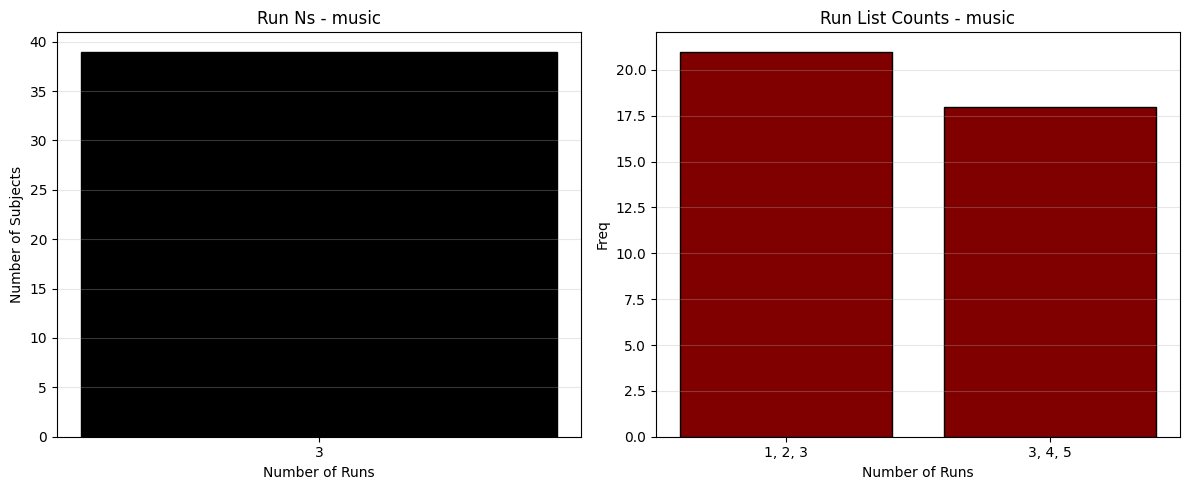

In [5]:
run_counts = df['num_runs'].value_counts().sort_index()
run_lists = df['run_numbers'].value_counts().sort_index()

# bar graph for number of runs per subject, a count of listed runs per sub
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(run_counts.index, run_counts.values, color='black', edgecolor='black')
ax1.set_xlabel('Number of Runs')
ax1.set_ylabel('Number of Subjects')
ax1.set_title(f'Run Ns - {taskname}')
ax1.set_xticks(run_counts.index)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(run_lists.index, run_lists.values, color='maroon', edgecolor='black')
ax2.set_xlabel('Number of Runs')
ax2.set_ylabel('Freq')
ax2.set_title(f'Run List Counts - {taskname}')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Generic Spec File

Setting up a generic specification file to extract BIDS model information. The specification below defines a simple one-sample t-test using the `SPM` HRF. We will run this with the `get_bidstats_events()` function to generate a model visualization. 

Physiological files that are not used in the analysis can be filtered out to prevent errors via:

```python
ignored=[r"sub-.*_physio\.(json|tsv\.gz)"]
```

The models below will be updated by replacing nodes within *this* specification. This approach allows us to reuse the same base specification across a multiverse of models by simply substituting node specifications for transformations, contrasts, X models, and group-comparisons.

In [10]:
gen_spec = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      'control01',
      'control02',
      'control03',
      'control04',
      'control05',
      'control06',
      'control07',
      'control08',
      'control09',
      'control10',
      'control11',
      'control12',
      'control13',
      'control14',
      'control15',
      'control16',
      'control17',
      'control18',
      'control19',
      'control20',
      'mdd01',
      'mdd02',
      'mdd03',
      'mdd04',
      'mdd05',
      'mdd06',
      'mdd07',
      'mdd08',
      'mdd09',
      'mdd10',
      'mdd11',
      'mdd12',
      'mdd13',
      'mdd14',
      'mdd15',
      'mdd16',
      'mdd17',
      'mdd18',
      'mdd19'
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "data_level", 
      "GroupBy": [
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    }
  ]
}

_, _, graph = get_bidstats_events(bids_inp, gen_spec, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

### First-Level (Run-Level) GLM

#### Traditional HRF Model

This is the core model applied to the BOLD time-series data for each individual run. It is estimated at every voxel $v$ in the brain. This is what is estimated in the **run_level** node.

$$Y_v = X\beta_v + \varepsilon_v$$

- $Y_v$: The vector of BOLD signal measurements over time at a single voxel $v$
- $X$: The **Design Matrix**. Each column is a regressor representing a hypothesized source of variance in the BOLD signal. This includes:
  - Task regressors (convolved with a hemodynamic response function)
  - Nuisance regressors (e.g., motion parameters, physiological noise)
  - Intercept (column of ones). The model's baseline (or mean signal, when all other regressors are zero) at the voxel, ensuring that the other regressors explain deviations *from* this baseline
- $\beta_v$: The vector of parameter estimates (beta weights) at voxel $v$. Each beta corresponds to the amplitude of the effect of one regressor in the design matrix (impacted by timing of events, convolution, and collinearity)
- $\varepsilon_v$: The vector of residual error (unexplained variance) at voxel $v$ over time

Can compute from the model: **contrast images** for each run. Simply a linear combination of beta weights that tests a specific hypothesis (e.g., `Task A > Task B`). Often good to compute VIFs for regressors and contrasts (e.g. tVIF and cVIF from [Mumford](https://github.com/jmumford/vif_contrasts))

#### Finite Impulse Response (FIR) First-Level (Run-Level) GLM

Similar to a traditional HRF model, the FIR model is estimated at every voxel $v$ in the brain.

$$Y_v = X\beta_v + \varepsilon_v$$

- $Y_v$: The vector of BOLD signal measurements over time at a single voxel $v$
- $X$: The **Design Matrix**. Each column is a regressor representing a hypothesized source of variance in the BOLD signal. This includes:
  - **FIR task regressors**: Multiple time-lagged versions of each task condition (not convolved with HRF)
  - Nuisance regressors (e.g., motion parameters, physiological noise)
  - Intercept (column of ones)
- $\beta_v$: The vector of parameter estimates (beta weights) at voxel $v$. **Each task condition now has multiple betas** - one for each time lag (e.g., `β_TaskA_lag1`, `β_TaskA_lag2`, `β_TaskA_lag3`)
- $\varepsilon_v$: The vector of residual error (unexplained variance) at voxel $v$ over time

**Key FIR Differences:**
- Each experimental condition generates multiple regressors (one per time lag, in *Volumes/TR*)
- Beta weights represent response amplitude at specific delays after stimulus onset 
- **Contrast specification** requires summing across time lags for condition-level effects or comparing specific lags
- More parameters → reduced degrees of freedom but increased flexibility in capturing HRF shape

Can compute **contrast images** by creating linear combinations that sum across time lags for each condition, then test hypotheses (e.g., `sum(Task_A_lags) > sum(Task_B_lags)`). VIF monitoring is especially important due to increased collinearity between lag regressors.

#### Run-level Node 

We will now get and run the *run_level* node in order to look into the variables and transations at this node. This is what BIDS-SM will run and prepare to pass downstream. The run level node name is derived from the field/key, which is within the spec file we specified above:

```python
...
"Name": "run_level",
...
```

In [11]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

##### Inspect Models

In [12]:
print(f"Given our subject N ({len(n_subjects)}, 3 runs per), we expect a subject-by-run counts of run_level models: {len(run_specs)}.\nEach `run_level` model has a root plus N = {(len(run_specs[0].trans_hist)-1)} transformations.")

Given our subject N (39, 3 runs per), we expect a subject-by-run counts of run_level models: 117.
Each `run_level` model has a root plus N = 2 transformations.


We can inspect each of the transformations for each of the subject indices using:

```python
subject = 0 # first subject
trans_hist = 0 # The input data, prior to any transormations ([-1] would be the last data matrix available to the model step)
run_specs[subject].trans_hist[trans_hist].output.to_df() 
```


We can obtain the first ten rows. This shows us what is available for subject at index 0 (e.g. control01) for the first model (e.g. run1). It indicates the onset, duration, trial types and task label. This is what is available for manipulation in the next transformations 

**NOTE**: This will not include the information available in the *_confounds.tsv file as we are only getting layout of BIDS input files such as events.

In [13]:
subject = 0 # first subject
trans_hist = 0 
run_specs[subject].trans_hist[trans_hist].output.to_df().head(10) # fit 10 rows

,onset,run,subject,duration,trial_type,task,suffix,datatype
0,0.0,1,control01,33.0,tones,music,bold,func
1,33.0,1,control01,3.0,response,music,bold,func
2,36.0,1,control01,31.5,negative_music,music,bold,func
3,67.5,1,control01,3.0,response,music,bold,func
4,70.5,1,control01,31.5,tones,music,bold,func
5,102.0,1,control01,3.0,response,music,bold,func
6,105.0,1,control01,31.5,positive_music,music,bold,func
7,136.5,1,control01,3.0,response,music,bold,func
8,139.5,1,control01,31.5,tones,music,bold,func
9,171.0,1,control01,3.0,response,music,bold,func


######  **Plot Model Design Matrix**


<Axes: label='conditions', ylabel='scan number'>

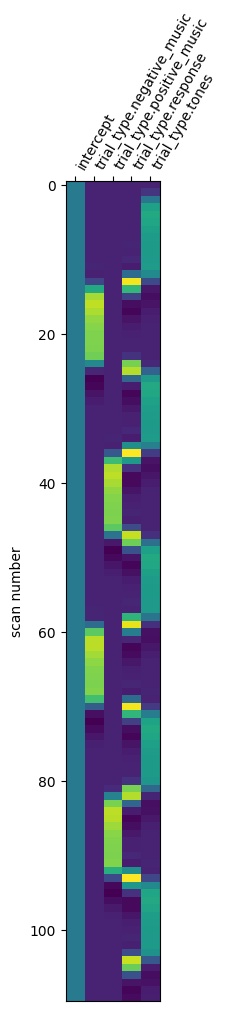

In [14]:
plot_design_matrix(run_specs[subject].X)

###### **Plot Model's HRF**

We can plot the HRF that will be regressed onto the brain data (at each voxel) in the model. For this example, the visual excludes the intercept and all-non convolved nusiance regressors.

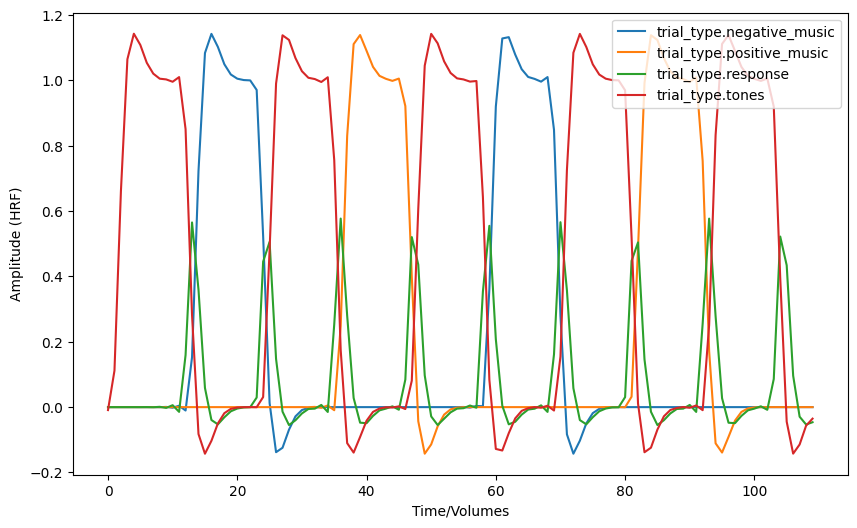

In [15]:
plt.figure(figsize=(10, 6))
data_to_plot = run_specs[subject].X

for i, col in enumerate(run_specs[subject].X.columns.difference(['intercept'])):
    plt.plot(data_to_plot[col], label=col)

plt.xlabel('Time/Volumes')
plt.ylabel('Amplitude (HRF)')
plt.legend(loc='upper right')
plt.show()

#### FIR Model Spec & Example

Here we will use the FIR model to convolve with our regressors. An FIR example is provided via Nilearn's First Level Model [here](https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_fir_model.html). We will use the "fir" HRF model and specify four spaced delays: 1, 3, 5, 7, meaning the model will estimate the hemodynamic response at four specific timepoints after stimulus onset. The value 1 corresponds to TR 1, 3 to TR 3 (i.e., volume 3), and so on. This generates a basis set of four regressors for *each* stimulus condition in our design matrix.

> **Note:** The spacing between FIR delays must be fixed. For this FIR specification, **we use a subset (N=4) of subjects for the example**.

We use the *identical* specification input as above, but update our first (run-level) node to reflect: 1) the updated convolution method (SPM → FIR) and 2) contrasts focused on specific temporal delays.

In [21]:
fir_spec = copy.deepcopy(gen_spec)

# Update the run level node (first node in the Nodes list)
fir_spec["Nodes"][0] = {
    "Level": "Run",
    "Name": "run_level",
    "GroupBy": [
        "run",
        "subject"
    ],
    "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
            {
                "Name": "Factor",
                "Input": [
                    "trial_type"
                ]
            },
            {
                "Name": "Convolve",
                "Model": "fir",
                "FIRDelays": [1, 2, 3],
                "Input": [
                    "trial_type.*"
                ]
            }
        ]
    },
    "Model": {
        "X": [
            1,
            "trial_type.positive_music_1",
            "trial_type.positive_music_2", 
            "trial_type.positive_music_3",
            "trial_type.negative_music_1",
            "trial_type.negative_music_2",
            "trial_type.negative_music_3", 
            "trial_type.tones_1",
            "trial_type.tones_2",
            "trial_type.tones_3",
            "trans_*",
            "rot_*",
            "cosine*"
        ],
        "Type": "glm"
    },
    "Contrasts": [
        {
            "Name": "musicvsounds_summed",
            "ConditionList": [
                "trial_type.positive_music_1",
                "trial_type.positive_music_2", 
                "trial_type.positive_music_3",
                "trial_type.negative_music_1",
                "trial_type.negative_music_2",
                "trial_type.negative_music_3", 
                "trial_type.tones_1",
                "trial_type.tones_2",
                "trial_type.tones_3",
            ],
            "Weights": [
                0.1667, 0.1667, 0.1667,
                0.1667, 0.1667, 0.1667,
                -0.333, -0.333, -0.333
            ],
            "Test": "t"
        },
        {
            "Name": "musicvsounds_lag3",
            "ConditionList": [
                "trial_type.positive_music_3",
                "trial_type.negative_music_3",
                "trial_type.tones_3"
            ],
            "Weights": [
                0.5,
                0.5,
                -1
            ],
            "Test": "t"
        }
    ]
}

# now, run our function with the updated fir_spec
_, _, graph_fir = get_bidstats_events(bids_inp, fir_spec, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [23]:
# obtain run-level model
firrun_level_node = graph_fir.get_node(name="run_level")
firrun_specs = firrun_level_node.run(
    group_by=firrun_level_node.group_by,
    force_dense=False,
    transformation_history=True
    
)

##### Inspect model

In [24]:
subject = 0 # first
firrun_specs[subject].trans_hist[1].output.to_df().head(50) # get first 5 rows

,onset,run,subject,duration,trial_type.negative_music,trial_type.positive_music,trial_type.response,trial_type.tones,task,datatype,suffix
0,0.0,1,control01,33.0,0.0,0.0,0.0,1.0,music,func,bold
1,33.0,1,control01,3.0,0.0,0.0,1.0,0.0,music,func,bold
2,36.0,1,control01,31.5,1.0,0.0,0.0,0.0,music,func,bold
3,67.5,1,control01,3.0,0.0,0.0,1.0,0.0,music,func,bold
4,70.5,1,control01,31.5,0.0,0.0,0.0,1.0,music,func,bold
5,102.0,1,control01,3.0,0.0,0.0,1.0,0.0,music,func,bold
6,105.0,1,control01,31.5,0.0,1.0,0.0,0.0,music,func,bold
7,136.5,1,control01,3.0,0.0,0.0,1.0,0.0,music,func,bold
8,139.5,1,control01,31.5,0.0,0.0,0.0,1.0,music,func,bold
9,171.0,1,control01,3.0,0.0,0.0,1.0,0.0,music,func,bold


##### Plot design matrix

Below is the design matrix and the estimated HRF response for each regressor in the model, which shows the estimated response at each of the four specified volumes/timepoints (TRs 1, 3, 5, and 7) following stimulus onset. This allows for flexible modeling of the response time course and does not assume a predetermined HRF shape like the SPM canonical approach above.

> Note, the PyBIDS convolution appears to contain an error, as the resulting matrix does not properly delay these lagged regressors. See *Nilearn* example below.

<Axes: label='conditions', ylabel='scan number'>

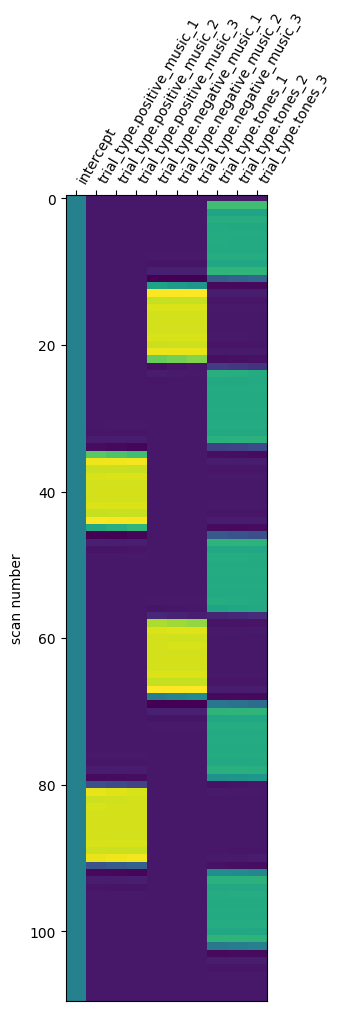

In [25]:
plot_design_matrix(firrun_specs[subject].X)

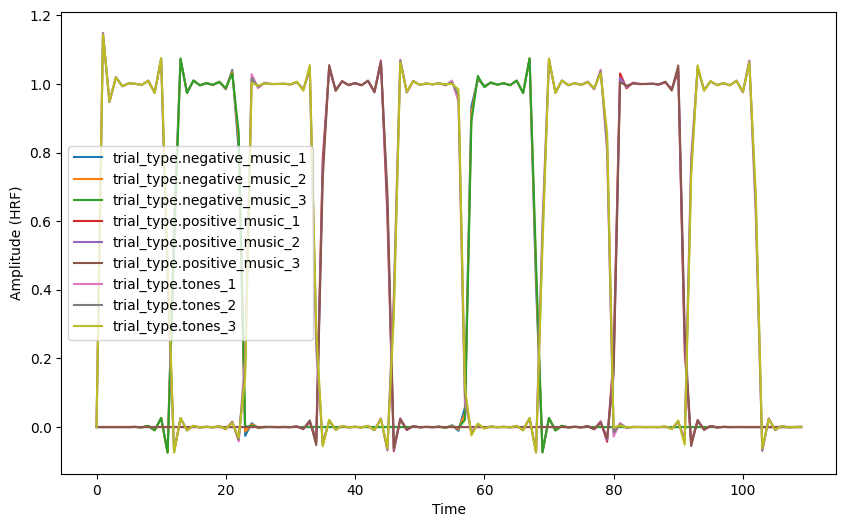

In [26]:
plt.figure(figsize=(10, 6))
data_to_plot = firrun_specs[subject].X

for i, col in enumerate(firrun_specs[subject].X.columns.difference(['intercept'])):
    plt.plot(data_to_plot[col], label=col)

plt.xlabel('Time')
plt.ylabel('Amplitude (HRF)')
plt.legend()
plt.show()

Here is a Nilearn example demonstrating the implementation error using identical design matrices and model fitting. The lower panel displays Nilearn's correctly constructed FIR design matrix, which exhibits the expected sustained temporal responses. In contrast, the upper panel shows the flawed non-Nilearn implementation that generates temporal aliasing artifacts and incorrect lag patterns rather than the intended FIR basis functions.

In [40]:
from nilearn.glm.first_level import make_first_level_design_matrix
events = firrun_specs[subject].trans_hist[0].output.to_df()[['onset','duration','trial_type']]
t_r = 3.0
vols = 110
events

design_events = pd.DataFrame({
                'onset': events['onset'],
                'duration': events['duration'],
                'trial_type': events['trial_type']
            })
frame_times = np.arange(vols) * t_r


design_matrix = make_first_level_design_matrix(
    frame_times=frame_times,
    events=design_events,
    hrf_model='fir',
    fir_delays=[1,2,3],
    drift_model=None,
)
design_matrix

,negative_music_delay_1,negative_music_delay_2,negative_music_delay_3,positive_music_delay_1,positive_music_delay_2,positive_music_delay_3,response_delay_1,response_delay_2,response_delay_3,tones_delay_1,tones_delay_2,tones_delay_3,constant
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
318.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
321.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
324.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: label='conditions', ylabel='scan number'>

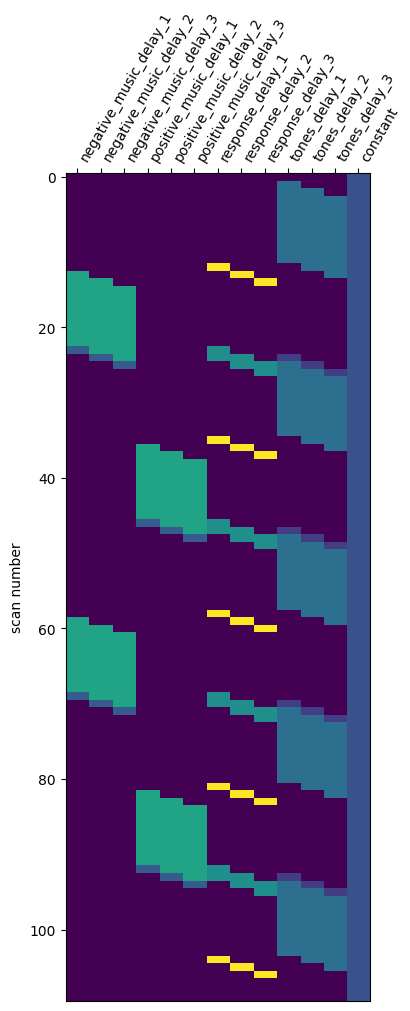

In [21]:
plot_design_matrix(design_matrix)

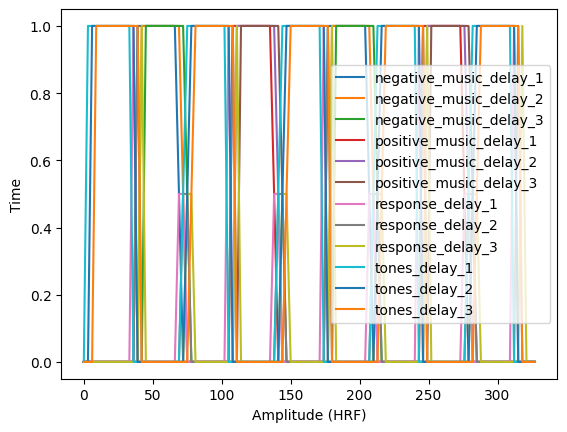

In [69]:
for i, col in enumerate(design_matrix.columns.difference(['constant'])):
    plt.plot(design_matrix[col], label=col)

plt.xlabel('Amplitude (HRF)')
plt.ylabel('Time')
plt.legend()
plt.show()

### Within-Subject Run Average / Differences (Subject-Level)

Estimates a single estimate of a task effect by averaging across multiple fMRI runs or taking a differences* of runs. Used in the group-level analysis. 


**a. Fixed-Effects Average**

Averages each contrast estimates across 1+ runs. *This is what can be estimated within the `Subject` node.*

Let $c_r(v)$ be the contrast value for run $r$ at voxel $v$. For a total of $R$ runs, the average contrast value is:

$$\bar{c}(v) = \frac{1}{R} \sum_{r=1}^{R} c_r(v)$$

- $\bar{c}(v)$: The average contrast value at voxel $v$
- $c_r(v)$: The contrast value from a single run $r$
- $R$: The total number of runs being averaged

**b. Within-Subject Paired Difference** * 

Compare the effect of a condition between two runs (or two different conditions within the same run). This is often used to test for effects like learning, adaptation or fatigue.

Let $c_{\text{run1}}(v)$ and $c_{\text{run2}}(v)$ be the contrast values for the same task contrasts in Run 1 and Run 2. The difference is:

$$c_{\text{diff}}(v) = c_{\text{run2}}(v) - c_{\text{run1}}(v)$$

- $c_{\text{diff}}(v)$: The resulting difference value at voxel $v$. This difference image is then used in a group-level one-sample t-test to see if the difference is consistent across subjects (significantly positive or negative activity rejects the null, no activity differene)


>  ***In the current version, it is not possible to compute the within-subj run difference model.**
 


At a future data, if run information is consistent, one can add the below model within the subject-level node to contrast runs:
```python
"Model": {
    "X": [
        "run"
    ],
    "Type": "meta",
    "Formula": "0 + C(run)"
}
```

Then, within the subject-level node, the contrasts may be specified as using:
```python
"Contrasts": [
    {
        "Name": "run1vrun2",
        "ConditionList": [
        "C(run)[1]",
        "C(run)[2]"
        ],
        "Weights": [
        1,
        -1
        ],
        "Test": "t"
    },
    {
        "Name": "run1vrun3",
        "ConditionList": [
        "C(run)[1]",
        "C(run)[3]"
        ],
        "Weights": [
        1,
        -1
        ],
        "Test": "t"
    }
]
```

However, until the Subject node is debugged, there is an error in this dataset whereby the design matrix (i.e. column-by-map indices representing the run-labels by the image number) will return a known error:
```python
ValueError: design_matrix does not match the number of maps considered. 3 rows in design matrix do not match with 9 maps.
```

#### Subject Level Node

To run our subject level node, we will need some information to pass in from the `run_specs` for it to proceed. Here, we get the list of contrasts to achieve this.

In [16]:
# get contrasts from https://github.com/poldracklab/fitlins/blob/35f9a0d440731f3ad5630c56bda2780878885794/fitlins/utils/bids.py#L48
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

##### Inspect Models

The output from our run-level should be equivalent to the product of:
1. Number of subjects
2. Number of runs
3. Number of contrasts

In other words, we get a single output for each subject, run and contrast. At the subject_level, we can take the average *across* runs within a subject.

In [17]:
run_level_node = next(node for node in gen_spec['Nodes'] if node['Name'] == 'run_level')
contrast_names = [contrast['Name'] for contrast in run_level_node['Contrasts']]

In [18]:
print(f"Given our subject N ({len(n_subjects)}, 3 runs per) and N = {len(contrast_names)} contrast, we expect a subject-by-run-by-contrast counts of models ran: {len(n_subjects)*3*len(contrast_names)}.")
print(f"\nThe resulting models at the subject level, as it is subject {len(n_subjects)} x {len(contrast_names)} contrasts, is N = {len(subject_outputs)}")

Given our subject N (39, 3 runs per) and N = 8 contrast, we expect a subject-by-run-by-contrast counts of models ran: 936.

The resulting models at the subject level, as it is subject 39 x 8 contrasts, is N = 312


Typically, the **subject_level** model may not need a transformation. So here, there will not be a "transformation" key. In this case, one can look into the meta data that is present for a given subject. Below is the meta data and model (e.g. averaging beta maps within subject across runs).

> Currently, transformations are not possible on the subjectlevel node.

In [19]:
subject_outputs[subject].metadata

,contrast,run,subject
0,musicvsounds,1,control01
1,musicvsounds,2,control01
2,musicvsounds,3,control01


Comparing the meta-data for Subject 1 and Subject 20 shown above and below, it is clear that while the run-level information is similar in structure, there are important differences. Specifically, both subjects have three runs, but Subject 1 has runs 1-3 while Subject 20 has runs 3-5. This difference is confirmed by the figures we created initially and poses a significant issue if we elect to run paired difference models at the subject-level node, as there will be different regressors available for contrasting across subjects. There is also a theoretical component to this labeling differences. If there is a different administration, how do fatigue and learning effects represented in the estimated univariate maps?

In [20]:
subject_outputs[subject+20].metadata

,contrast,run,subject
0,posmusic,3,control03
1,posmusic,4,control03
2,posmusic,5,control03


######  **Model Matrix**


In [29]:
subject_outputs[subject].X

,intercept
0,1
1,1
2,1


### Group-Level 

This second-level model is used to make inferences about a population from the sample of subjects. In a one-sample t-test, the test whether the mean effect across all subjects is significantly different from zero (typically, two-sided). In a two-sample independent t-test, the test whether the mean effect between groups is significantly different from zero (two-sided). In a 2+ group ANOVA, the test whether across all groups there is a difference that is significantly different from zero. The input data are the contrast images from step 1 and/or 2.

**One-Sample t-test** 

The model is applied at each voxel $v$ across subjects $i$:

$$c_v(i) = \mu_v + \varepsilon_v(i)$$

- $c_v(i)$: The contrast value (e.g., the result of `Task A > Task B`) for subject $i$ at voxel $v$. This is the dependent variable
- $\mu_v$: The group mean effect at voxel $v$. This is the parameter we are estimating ($\beta_0$ in a more complex model)
- $\varepsilon_v(i)$: The between-subject error for subject $i$ at voxel $v$. It represents the deviation of each subject's effect from the group mean

The null hypothesis for the one-sample t-test is $H_0: \mu_v = 0$. Rejecting the null hypothesis indicates that there is a consistent, non-zero effect across the group at that voxel.

**Two-Sample Independent t-test** 

For comparing two groups (e.g., patients vs. controls), the model at each voxel $v$ is:

$c_v(i) = \beta_{1v} \cdot G_{1i} + \beta_{2v} \cdot G_{2i} + \varepsilon_v(i)$

- $c_v(i)$: The contrast value for subject $i$ at voxel $v$
- $\beta_{1v}$: The mean effect for group 1 at voxel $v$
- $\beta_{2v}$: The mean effect for group 2 at voxel $v$
- $G_{1i}$: Group 1 indicator (1 if subject $i$ is in group 1, 0 otherwise)
- $G_{2i}$: Group 2 indicator (1 if subject $i$ is in group 2, 0 otherwise)
- $\varepsilon_v(i)$: The between-subject error for subject $i$ at voxel $v$

The null hypothesis is $H_0: \beta_{1v} = \beta_{2v}$, typically tested with the contrast $[1, -1]$ (group 1 > group 2) or $[-1, 1]$ (group 2 > group 1). Rejecting the null hypothesis indicates that there is a significant difference between the two groups at that voxel.

**2+ Group ANOVA** 

For comparing three or more groups, the model at each voxel $v$ is:

$c_v(i) = \sum_{j=1}^{k} \beta_{jv} \cdot G_{ji} + \varepsilon_v(i)$

- $c_v(i)$: The contrast value for subject $i$ at voxel $v$
- $\beta_{jv}$: The mean effect for group $j$ at voxel $v$
- $G_{ji}$: Group indicator for group $j$ (1 if subject $i$ belongs to group $j$, 0 otherwise)
- $k$: Total number of groups
- $\varepsilon_v(i)$: The between-subject error for subject $i$ at voxel $v$

The null hypothesis is $H_0: \beta_{1v} = \beta_{2v} = \ldots = \beta_{kv}$. This omnibus test is typically implemented using an F-statistic to test whether all group means are equal. Rejecting the null hypothesis indicates that there is at least one significant difference among the groups at that voxel. Specific contrasts can then be used to test particular hypotheses, such as $[1, -1, 0]$ to compare groups 1 and 2, or $[1, 1, -2]$ to compare the average of groups 1 and 2 against group 3.

#### Run 'dataset_level' node

After fitting run and subject level runs (within subject), we can compute the group level between-subject models. Like in run_level, we can access the transformation history to create covariate model adjusting for age. We will demean age so zero means "average" age here in the model.

In [30]:
# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="data_level")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

In [31]:
print(f"The data level node fits a model for each of the N = {len(dataset_outputs)} contrasts.")

The data level node fits a model for each of the N = 8 contrasts.


Similar to the runLevel node, the dataLevel node contains options for transformations. While not used in this example (more on this in examples below), the node has access to information located within the `participants.tsv` file at the BIDS root folder. In this case, that includes the subject, age, group, and sex variables that can be incorporated into the group-level model.

These participant variables can be used in several ways. For example:

**As regressors:**
- Age as a continuous covariate to examine age-related effects
- Sex as a categorical regressor to control for sex differences

**As contrasts:**
- Group comparisons (e.g., patients vs. controls)
- Sex differences (e.g., male vs. female responses)
- Age group comparisons (e.g., young vs. old, w/ appropriate bis)

**Example applications:**
- Testing whether brain activation differs between experimental groups while controlling for age
- Examining whether the effect of interest varies as a function of participant age
- Investigating sex-specific responses to the experimental conditionals



In [32]:
dataset_outputs[0].trans_hist[0].output.to_df(entities=True).head(15)

,subject,age,group,sex,suffix
0,control01,19,Never-Depressed Control,F,participants
1,control02,22,Never-Depressed Control,M,participants
2,control03,18,Never-Depressed Control,F,participants
3,control04,19,Never-Depressed Control,M,participants
4,control05,27,Never-Depressed Control,M,participants
5,control06,31,Never-Depressed Control,M,participants
6,control07,31,Never-Depressed Control,F,participants
7,control08,18,Never-Depressed Control,M,participants
8,control09,24,Never-Depressed Control,F,participants
9,control10,23,Never-Depressed Control,F,participants


######  **Plot Model Matrix**

Here, the model representated as only an intercept (e.g., mean-model)

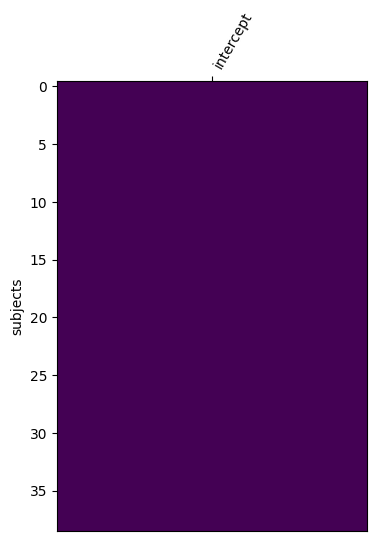

In [35]:
fig, ax = plt.subplots(figsize=(4, 0.15 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

# <span style="color: red;">**Group Statistical Model Examples**</span>

## **One Sample T-test**

In this case, we are performing a one-sample t-test, which tests whether the voxelwise average brain activity across all subjects' contrast maps is significantly different from zero (H₀: μ = 0 vs. H₁: μ ≠ 0). This is the simplest group-level analysis, as it treats all subjects as coming from a single population and averages their individual contrast estimates.

**What this means:**
- All subjects contribute equally to the group average
- The analysis assumes homogeneity across subjects (no individual differences modeled)
- The resulting statistical map shows where brain activity is consistently above or below baseline across the sample

In [63]:
# the one sample t-test is the copy of our generic spec file from above with node name relabeled
onesample_t = copy.deepcopy(gen_spec)
onesample_t['Nodes'][-1] = {
    "Level": "Dataset",
    "Name": "onesample_t", 
    "GroupBy": [
    "contrast"
    ],
    "Model": {
    "X": [
        1
    ],
    "Type": "glm"
    },
    "DummyContrasts": {
    "Test": "t"
    }
}

_, _, graph = get_bidstats_events(bids_inp, onesample_t, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [2]:
effect_maps = [['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model0/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model0/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model0/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model0/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model1/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model1/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model1/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model1/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model2/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model2/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model2/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model2/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model3/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model3/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model3/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model3/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model4/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model4/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model4/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model4/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model5/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model5/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model5/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model5/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model6/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model6/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model6/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model6/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model7/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model7/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model7/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model7/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model8/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model8/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model8/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model8/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model9/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model9/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model9/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model9/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model10/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model10/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model10/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model10/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model11/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model11/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model11/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model11/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model12/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model12/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model12/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model12/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model13/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model13/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model13/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model13/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model14/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model14/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model14/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model14/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model15/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model15/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model15/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model15/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model16/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model16/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model16/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model16/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model17/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model17/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model17/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model17/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model18/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model18/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model18/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model18/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model19/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model19/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model19/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model19/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model20/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model20/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model20/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model20/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model21/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model21/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model21/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model21/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model22/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model22/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model22/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model22/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model23/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model23/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model23/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model23/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model24/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model24/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model24/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model24/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model25/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model25/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model25/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model25/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model26/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model26/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model26/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model26/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model27/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model27/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model27/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model27/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model28/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model28/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model28/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model28/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model29/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model29/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model29/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model29/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model30/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model30/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model30/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model30/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model31/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model31/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model31/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model31/posmusicvsounds_effect_size.nii.gz'], ['/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model32/musicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model32/posmusicvnegmusic_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model32/negmusicvsounds_effect_size.nii.gz', '/scratch/groups/russpold/demidenm/bidssm_fitlins/fitlins/task-music_paireddiff/fitlins_wf/l1_model/mapflow/_l1_model32/posmusicvsounds_effect_size.nii.gz']]
len(effect_maps)

33

In [3]:
stat_metadata = [[{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control01', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control01', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control01', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control01', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control01', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control01', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control01', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control01', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control01', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control01', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control01', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control01', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control02', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control02', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control02', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control02', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control02', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control02', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control02', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control02', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control02', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control02', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control02', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control02', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control07', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control07', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control07', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control07', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control07', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control07', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control07', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control07', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control07', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control07', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control07', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control07', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control08', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control08', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control08', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control08', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control08', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control08', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control08', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control08', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control08', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control08', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control08', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control08', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control09', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control09', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control09', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control09', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control09', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control09', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control09', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control09', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control09', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control09', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control09', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control09', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control10', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control10', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control10', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control10', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control10', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control10', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control10', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control10', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control10', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control10', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control10', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control10', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control11', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control11', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control11', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control11', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control11', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control11', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control11', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control11', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control11', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control11', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control11', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control11', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control13', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control13', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control13', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control13', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control13', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control13', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control13', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control13', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control13', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control13', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control13', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control13', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control15', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control15', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control15', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control15', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control15', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control15', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control15', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control15', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control15', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control15', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control15', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control15', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control18', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control18', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control18', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control18', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control18', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control18', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control18', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control18', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control18', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control18', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control18', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control18', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control20', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control20', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control20', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 1, 'subject': 'control20', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control20', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control20', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control20', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 2, 'subject': 'control20', 'contrast': 'posmusicvsounds'}], [{'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control20', 'contrast': 'musicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control20', 'contrast': 'posmusicvnegmusic'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control20', 'contrast': 'negmusicvsounds'}, {'name': 'run_level', 'level': 'run', 'stat': 't', 'run': 3, 'subject': 'control20', 'contrast': 'posmusicvsounds'}]]
len(stat_metadata)

33

In [64]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="onesample_t")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

### Data Input

In [65]:
dataset_outputs[0].trans_hist[0].output.to_df(entities=True).head(10)

,subject,age,group,sex,suffix
0,control01,19,Never-Depressed Control,F,participants
1,control02,22,Never-Depressed Control,M,participants
2,control03,18,Never-Depressed Control,F,participants
3,control04,19,Never-Depressed Control,M,participants
4,control05,27,Never-Depressed Control,M,participants
5,control06,31,Never-Depressed Control,M,participants
6,control07,31,Never-Depressed Control,F,participants
7,control08,18,Never-Depressed Control,M,participants
8,control09,24,Never-Depressed Control,F,participants
9,control10,23,Never-Depressed Control,F,participants


### Model Matrix

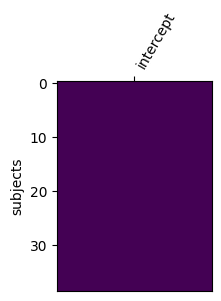

In [66]:
fig, ax = plt.subplots(figsize=(2, 0.07 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

### Statistical Maps

Average effective of `Music versus Sounds` contrats across subjects.

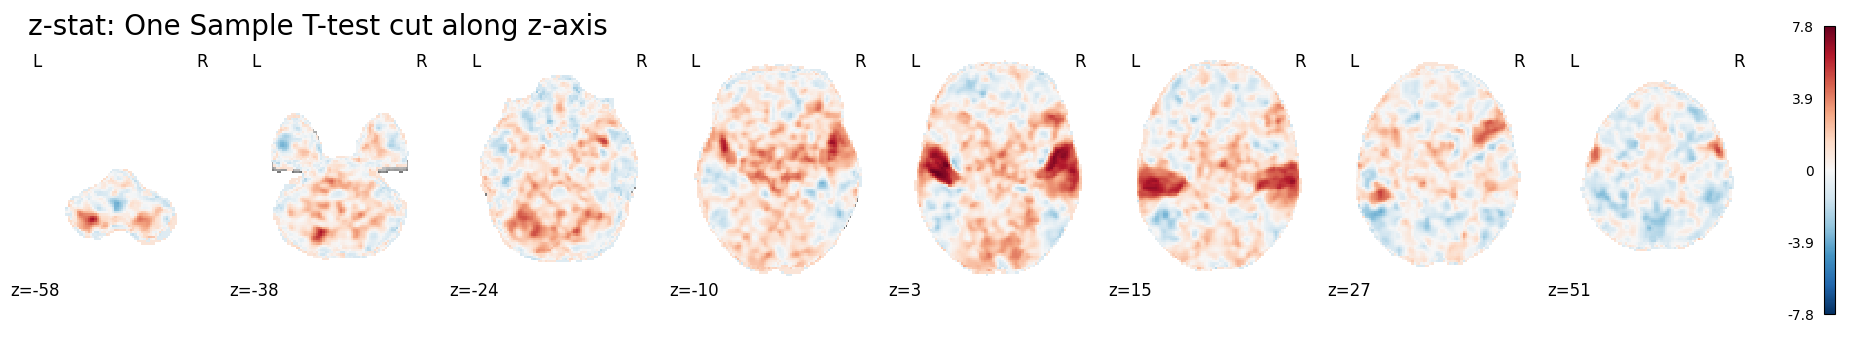

In [39]:
model = 'One Sample T-test'
map_type = 'z'
out_model = 'node-onesampleT'
contrast_name = 'contrast-musicvsounds'
img = f'{ex_results}/{out_model}/{contrast_name}_stat-{map_type}_statmap.nii.gz'
display = plot_stat_map(img, display_mode="z", cut_coords=8, 
                      title=None)
display.title(f"{map_type}-stat: {model} cut along z-axis", size=20, color='black', bgcolor='white', alpha=0)
plt.show()

## **One Sample T-test w/ Covariate**

In this case, we are transforming the `age` variable from the `participants.tsv` file located in the BIDS root directory. This transformation allows us to incorporate age as a covariate in our group-level model, enabling us to test hypotheses about age-related effects (H₀: β_age = 0 vs. H₁: β_age ≠ 0) or control for age-related variance.


In [67]:
onesample_tcov = copy.deepcopy(gen_spec)

# In this instance, our spec is identical to the generic above, we are just updating the last, data-level node.
onesample_tcov["Nodes"][-1] = {
      "Level": "Dataset",
      "Name": "onesample_tcov", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Demean",
            "Input": [
              "age"
            ],
            "Output": [
                "age_cent"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "age_cent"
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    }
_, _, graph = get_bidstats_events(bids_inp, onesample_tcov, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [44]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="onesample_tcov")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

### Data Input

**Step 1: Did the transformation take place?**

We want to inspect the transformation to ensure that:
1. The transformation took place successfully
2. The transformation worked correctly (proper scaling, no missing values, expected range)

Since we only have a single transformation in this example, we can examine the last (and only) index using `[-1]` to access the most recent transformation in the history.

In [47]:
dataset_outputs[0].trans_hist[-1].output.to_df(entities=True).head(5)

,subject,age,age_cent,group,sex,suffix
0,control01,19,-12.435897,Never-Depressed Control,F,participants
1,control02,22,-9.435897,Never-Depressed Control,M,participants
2,control03,18,-13.435897,Never-Depressed Control,F,participants
3,control04,19,-12.435897,Never-Depressed Control,M,participants
4,control05,27,-4.435897,Never-Depressed Control,M,participants


**Step 2: Did the transformation work correctly?** 

We can plot the distribution of our `age` (original) and `age_center` (transformed/demeaned) variables.

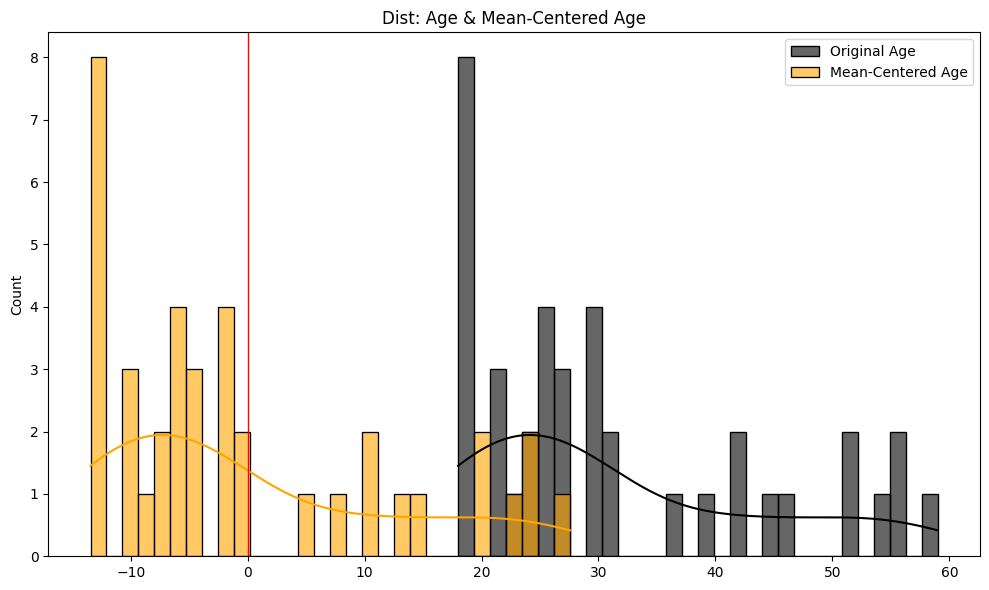

In [48]:

plt.figure(figsize=(10, 6))
sns.histplot(grp_df['age'], bins=30, color='black', kde=True, label='Original Age', alpha=0.6)
sns.histplot(grp_df['age_cent'], bins=30, color='orange', kde=True, label='Mean-Centered Age', alpha=0.6)
plt.axvline(0, color='red', linestyle='-', linewidth=1)
plt.title('Dist: Age & Mean-Centered Age')
plt.xlabel('')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

### Model Matrix

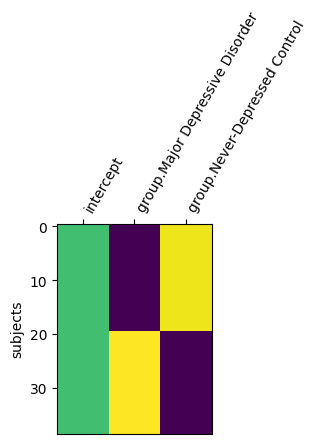

In [61]:
fig, ax = plt.subplots(figsize=(2, 0.07 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

### Statistical Map

Population-level brain activation for `Music versus Sounds` contrast (intercept term) and the linear association between participant `age` and the magnitude of this contrast effect (age covariate)

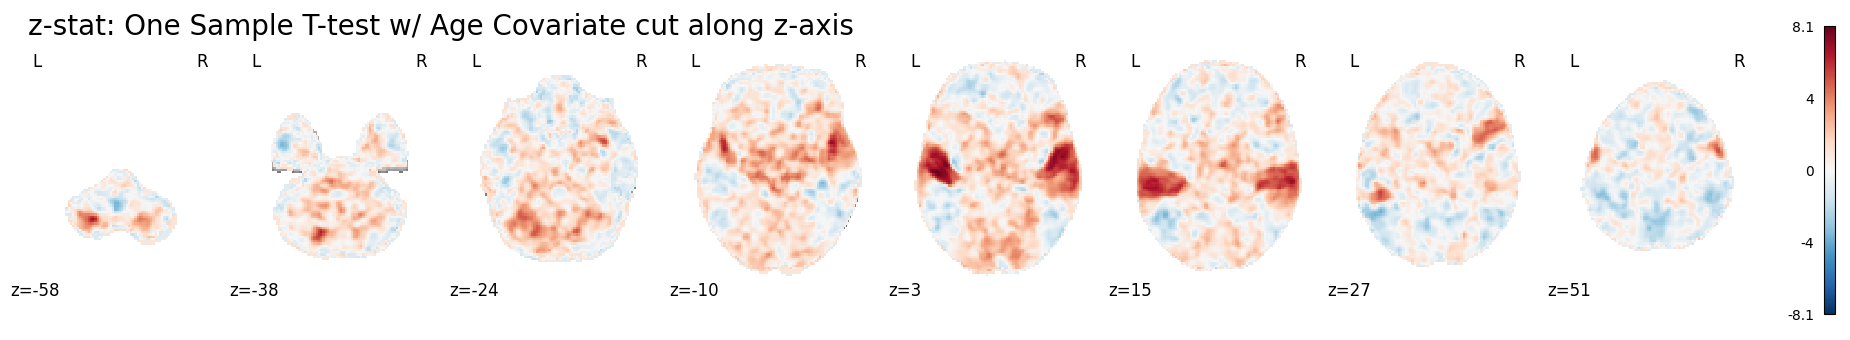

In [50]:
model = 'One Sample T-test w/ Age Covariate'
map_type = 'z'
out_model = 'node-onesampleTcov'
contrast_name = 'contrast-musicvsounds'
img = f'{ex_results}/{out_model}/{contrast_name}_stat-{map_type}_statmap.nii.gz'
display = plot_stat_map(img, display_mode="z", cut_coords=8, 
                      title=None)
display.title(f"{map_type}-stat: {model} cut along z-axis", size=20, color='black', bgcolor='white', alpha=0)
plt.show()

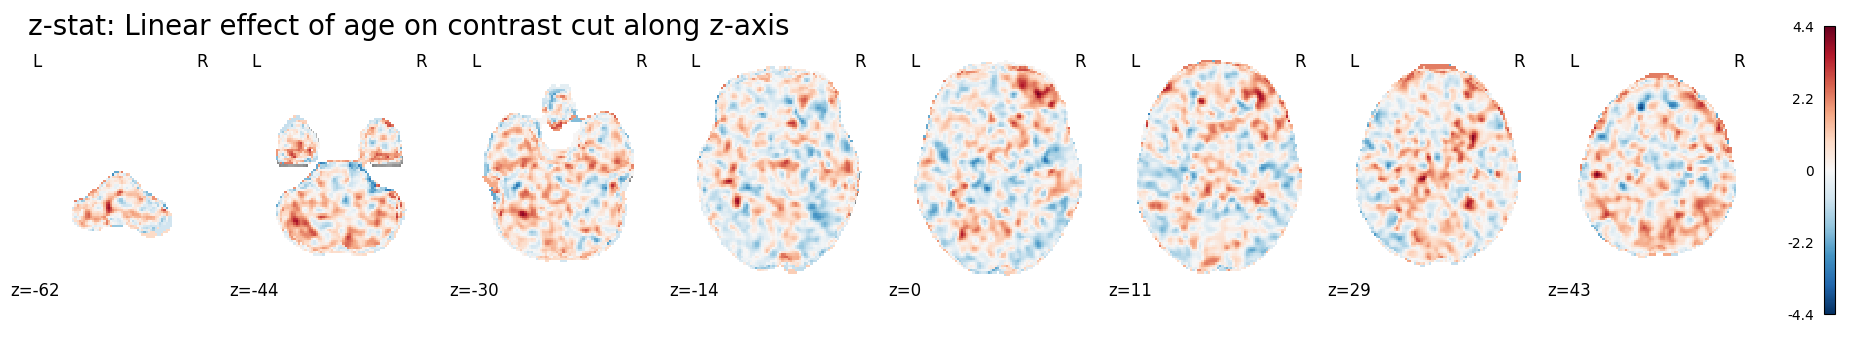

In [51]:
model = 'Linear effect of age on contrast'
map_type = 'z'
out_model = 'node-onesampleTcov'
contrast_name = 'contrast-musicvsoundsAgeCent'
img = f'{ex_results}/{out_model}/{contrast_name}_stat-{map_type}_statmap.nii.gz'
display = plot_stat_map(img, display_mode="z", cut_coords=8, 
                      title=None)
display.title(f"{map_type}-stat: {model} cut along z-axis", size=20, color='black', bgcolor='white', alpha=0)
plt.show()

## **Two-sample T-test**

Everything here is similar to the one-sample t-test, but now we are performing a two-sample t-test, which tests whether there are significant differences in brain activity between two groups (H₀: μ₁ - μ₂ = 0 vs. H₁: μ₁ - μ₂ ≠ 0). This allows us to compare activation patterns between conditions such as patients vs. controls, or different groups available within the data (e.g. sex).

- Each subject contributes to their respective group mean
- The model can estimate separate effects for each group
- Contrasts can directly compare groups (e.g., patients > controls)
- The resulting statistical map shows where groups differ significantly

In [52]:
twosample_t = copy.deepcopy(gen_spec)

# In this instance, our spec is identical to the generic above, we are just updating the last, data-level node.
twosample_t["Nodes"][-1] = {
      "Level": "Dataset",
      "Name": "twosample_t", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "group.*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "control_vs_mdd",
          "ConditionList": [
            "group.control",
            "group.mdd"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "mddvcontrol", 
          "ConditionList": [
            "group.Major Depressive Disorder",
            "group.Never-Depressed Control"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        }
      ]
    }

_, _, graph = get_bidstats_events(bids_inp, twosample_t, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [53]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="twosample_t")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

#### Data Input

The key difference is that we now have a group transformation in the model specification file that "factorizes" the group labels. This transformation creates separate group columns with 1s and 0s (dummy coding), effectively creating a multi-column group data matrix where each column represents membership in a specific group. This enables the statistical comparison of group means at each voxel.

In [54]:
grp_df = dataset_outputs[0].trans_hist[1].output.to_df(entities=True)
grp_df.head(5)

,subject,age,group.Major Depressive Disorder,group.Never-Depressed Control,sex,suffix
0,control01,19,0.0,1.0,F,participants
1,control02,22,0.0,1.0,M,participants
2,control03,18,0.0,1.0,F,participants
3,control04,19,0.0,1.0,M,participants
4,control05,27,0.0,1.0,M,participants


#### Model Matrix

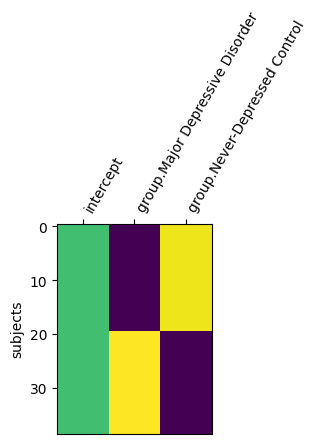

In [60]:
fig, ax = plt.subplots(figsize=(2, 0.07 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

### Statistical Maps

Average effective of `Music versus Sounds` compared Depressed versus Controls.

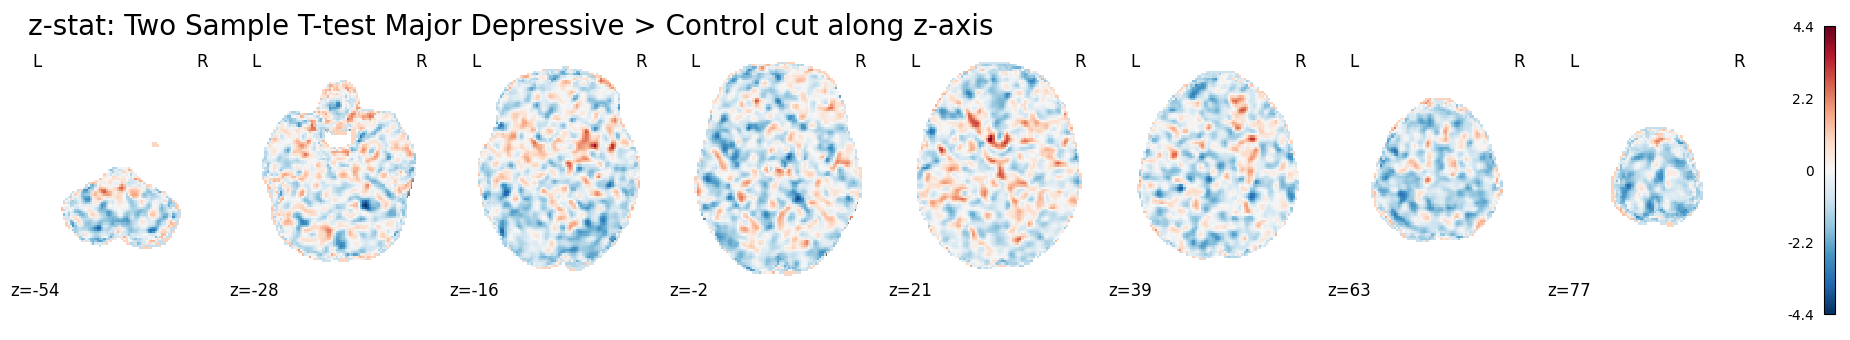

In [68]:
model = 'Two Sample T-test Major Depressive > Control'
map_type = 'z'
out_model = 'node-twosampleT'
contrast_name = 'contrast-musicvsoundsMddvcontrol'
img = f'{ex_results}/{out_model}/{contrast_name}_stat-{map_type}_statmap.nii.gz'
display = plot_stat_map(img, display_mode="z", cut_coords=8, 
                      title=None)
display.title(f"{map_type}-stat: {model} cut along z-axis", size=20, color='black', bgcolor='white', alpha=0)
plt.show()

## **Two-sample T-test w/ Covariate**

The data input will be similar to the one-sample t-test with our mean-centered age covariate and our two-sample t-test comparing groups, but now we are performing a two-sample t-test between our groups with age as a covariate. This tests whether there are significant group differences in brain activity while controlling for age effects (H₀: μ₁ - μ₂ = 0 | age vs. H₁: μ₁ - μ₂ ≠ 0 | age). This faciliates:

- Compare groups while removing age-related variance
- Test whether group differences persist after accounting for age
- Examine age effects that are *independent* of group membership


In [69]:
twosample_tcov = copy.deepcopy(gen_spec)

twosample_tcov['Nodes'][-1] = {
      "Level": "Dataset",
      "Name": "twosample_tcov", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Demean",
            "Input": [
              "age"
            ],
            "Output": [
                "age_cent"
            ]
          },
          {
            "Name": "Factor",
            "Input": [
              "group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "group.*",
          "age_cent"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "agecent",
          "ConditionList": [
            "age_cent"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "mddvcontrol", 
          "ConditionList": [
            "group.Major Depressive Disorder",
            "group.Never-Depressed Control"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        }
      ]
    }

_, _, graph = get_bidstats_events(bids_inp, twosample_tcov, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [70]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="twosample_tcov")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

#### Data Input 

We now have **two transformations** applied sequentially:

**Transformation 1: Mean-center age**
- Takes the continuous age variable from `participants.tsv`
- Subtracts the sample mean age from each participant's age
- Centers the covariate around zero for easier interpretation (i.e., difference when age is average, as opposed to implausible "zero")

**Transformation 2: Factorize groups**  
- Takes categorical group labels (e.g., "patient", "control")
- Creates separate columns for group membership



In [71]:
grp_df = dataset_outputs[0].trans_hist[1].output.to_df(entities=True)
grp_df.head(3)

,subject,age,age_cent,group,sex,suffix
0,control01,19,-12.435897,Never-Depressed Control,F,participants
1,control02,22,-9.435897,Never-Depressed Control,M,participants
2,control03,18,-13.435897,Never-Depressed Control,F,participants


In [72]:
grp_df = dataset_outputs[0].trans_hist[2].output.to_df(entities=True)
grp_df.head(3)

,subject,age,age_cent,group.Major Depressive Disorder,group.Never-Depressed Control,sex,suffix
0,control01,19,-12.435897,0.0,1.0,F,participants
1,control02,22,-9.435897,0.0,1.0,M,participants
2,control03,18,-13.435897,0.0,1.0,F,participants


#### Model Matrix

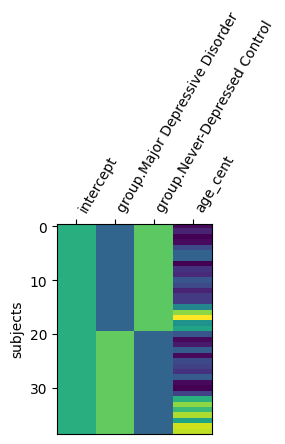

In [74]:
fig, ax = plt.subplots(figsize=(2, .07 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

### Statistical Maps

Average effective of `Music versus Sounds` comparing Major Depressive group versus Control, covariated for `age`

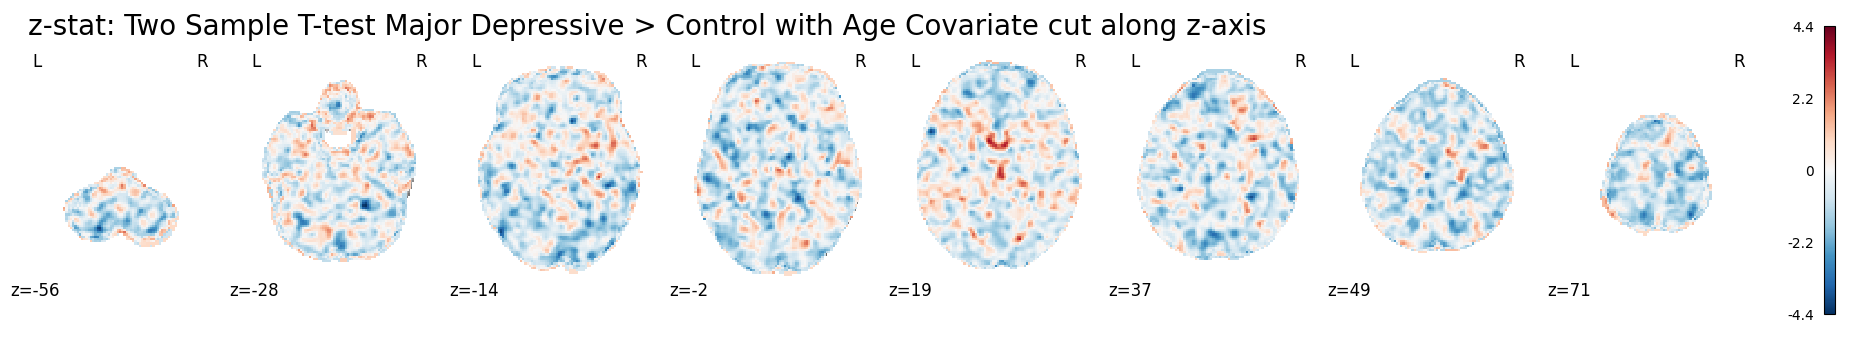

In [75]:
model = 'Two Sample T-test Major Depressive > Control with Age Covariate'
map_type = 'z'
out_model = 'node-twosampleTcov'
contrast_name = 'contrast-musicvsoundsMddvcontrol'
img = f'{ex_results}/{out_model}/{contrast_name}_stat-{map_type}_statmap.nii.gz'
display = plot_stat_map(img, display_mode="z", cut_coords=8, 
                      title=None)
display.title(f"{map_type}-stat: {model} cut along z-axis", size=20, color='black', bgcolor='white', alpha=0)
plt.show()

## **Two Group Continuous Interaction**

In this case, we are performing a two-group continuous interaction analysis. This tests whether the relationship between age and brain activity differs between groups (H₀: β_age×group = 0 vs. H₁: β_age×group ≠ 0). The model allows us to examine whether age effects are *moderated* by group membership—for instance. Specifically, it allows us to ask whether age-related changes in brain activity are steeper (slopes) in patients compared to controls.


In [76]:
twosample_tcovint = copy.deepcopy(gen_spec)

twosample_tcovint['Nodes'][-1] = {
    "Level": "Dataset",
    "Name": "twosample_tcovint", 
    "GroupBy": [
      "contrast"
    ],
    "Transformations": {
      "Transformer": "pybids-transforms-v1",
      "Instructions": [
        {
          "Name": "Factor",
          "Input": [
            "group"
          ]
        },
        {
          "Name": "Product",
          "Input": ["age", "group.Major Depressive Disorder"],
          "Output": "age_mdd"
        },
        {
          "Name": "Product",
          "Input": ["age", "group.Never-Depressed Control"],
          "Output": "age_control"
        }
      ]
    },
    "Model": {
      "X": [
        1,
        "group.*",
        "age_control",
        "age_mdd"

      ],
      "Type": "glm"
    },
    "Contrasts": [
      {
        "Name": "ageintcontrolvmdd", 
        "ConditionList": [
          "age_control",
          "age_mdd"
        ],
        "Weights": [
          1,
          -1
        ],
        "Test": "t"
      }
    ]
}
_, _, graph = get_bidstats_events(bids_inp, twosample_tcovint, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [77]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="twosample_tcovint")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

#### Data Input

Here, we need to generate separate age variables for *each* group. Earlier examples used a Python function, as it would be cumbersome to manually generate multiple group-specific age variables with comparable sample sizes. However, here we combine two transformation types sequentially:
 
**Transformation 1: Factor**
Creates separate binary indicator columns for each group level:
- "Major Depressive Disorder" column: 1 = MDD participant, 0 = not MDD
- "Never-Depressed Control" column: 1 = control participant, 0 = not control

**Transformation 2: Product**
Multiplies the continuous age variable by each group indicator to create group-specific age variables:

```json
{
  "Name": "Product",
  "Input": ["age", "group.Major Depressive Disorder"],
  "Output": "age_mdd"
},
{
  "Name": "Product", 
  "Input": ["age", "group.Never-Depressed Control"],
  "Output": "age_control"
}
```

**What this creates:**
- `age_mdd`: Age values for MDD participants, 0 for controls
- `age_control`: Age values for control participants, 0 for MDD participants
- This allows separate age slopes to be estimated for each group

In [78]:
grp_df = dataset_outputs[0].trans_hist[-1].output.to_df(entities=True)
grp_df.head(5)

,subject,age,age_control,age_mdd,group.Major Depressive Disorder,group.Never-Depressed Control,sex,suffix
0,control01,19,19.0,0.0,0.0,1.0,F,participants
1,control02,22,22.0,0.0,0.0,1.0,M,participants
2,control03,18,18.0,0.0,0.0,1.0,F,participants
3,control04,19,19.0,0.0,0.0,1.0,M,participants
4,control05,27,27.0,0.0,0.0,1.0,M,participants


We can plot the distributions of the two new variables (`age_mdd` and `age_control`) alongside our original age variable. Since we applied no additional transformations to the data beyond the group-specific splitting, the distributions should show apparent overlap that is consistent with the original data structure.


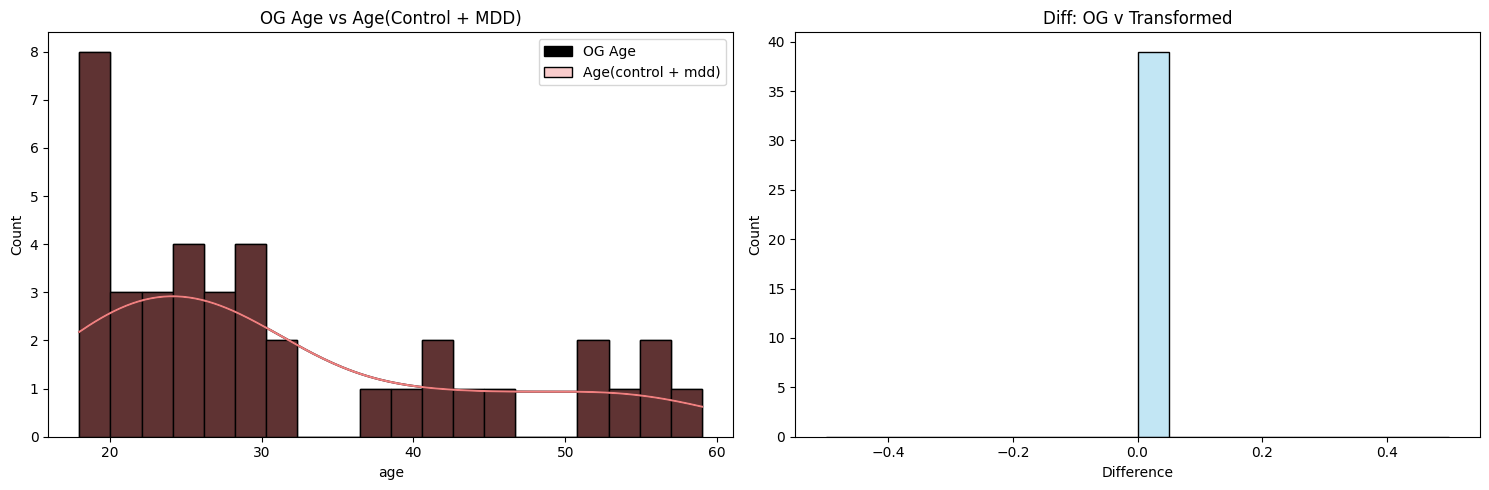

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# dist plot of ages
age_reconstructed = grp_df['age_control'] + grp_df['age_mdd']
sns.histplot(grp_df['age'], bins=20, color='black', kde=True, alpha=1, 
             label='OG Age', ax=ax1)
sns.histplot(age_reconstructed, bins=20, color='lightcoral', kde=True, alpha=0.4, 
             label='Age(control + mdd)', ax=ax1)
ax1.set_title('OG Age vs Age(Control + MDD)')
ax1.legend()

age_difference = grp_df['age'] - age_reconstructed
sns.histplot(age_difference, bins=20, color='skyblue', kde=True, alpha=0.5, ax=ax2)
ax2.set_title('Diff: OG v Transformed')
ax2.set_xlabel('Difference')

plt.tight_layout()
plt.show()

### Model Matrix

The model we are estimating at the group-level is below. The group-by-age effect is calculated by comparing the differences in slope/linear association between `age_control > age_mdd`

In [82]:
dataset_outputs[0].X

,intercept,group.Major Depressive Disorder,group.Never-Depressed Control,age_control,age_mdd
0,1.0,0.0,1.0,19.0,0.0
1,1.0,0.0,1.0,22.0,0.0
2,1.0,0.0,1.0,18.0,0.0
3,1.0,0.0,1.0,19.0,0.0
4,1.0,0.0,1.0,27.0,0.0
5,1.0,0.0,1.0,31.0,0.0
6,1.0,0.0,1.0,31.0,0.0
7,1.0,0.0,1.0,18.0,0.0
8,1.0,0.0,1.0,24.0,0.0
9,1.0,0.0,1.0,23.0,0.0


In [87]:
dataset_outputs[0].X.columns

Index(['intercept', 'group.Major Depressive Disorder',
       'group.Never-Depressed Control', 'age_control', 'age_mdd'],
      dtype='object')

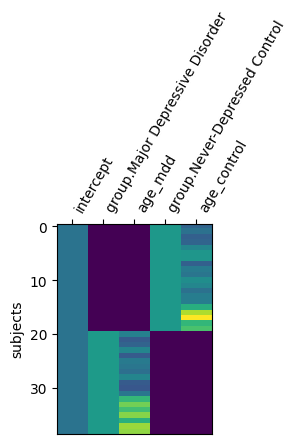

In [89]:
X_reordered = dataset_outputs[0].X[['intercept','group.Major Depressive Disorder', 'age_mdd', 'group.Never-Depressed Control','age_control']]
fig, ax = plt.subplots(figsize=(2, 0.07 * len(X_reordered)))
plot_design_matrix(X_reordered, axes=ax)
ax.set_ylabel("subjects")
plt.show()

### Statistical Maps

Average effective of `Music versus Sounds` comparing the slopes of age controls versus participants with Major Depression Diagnosis.

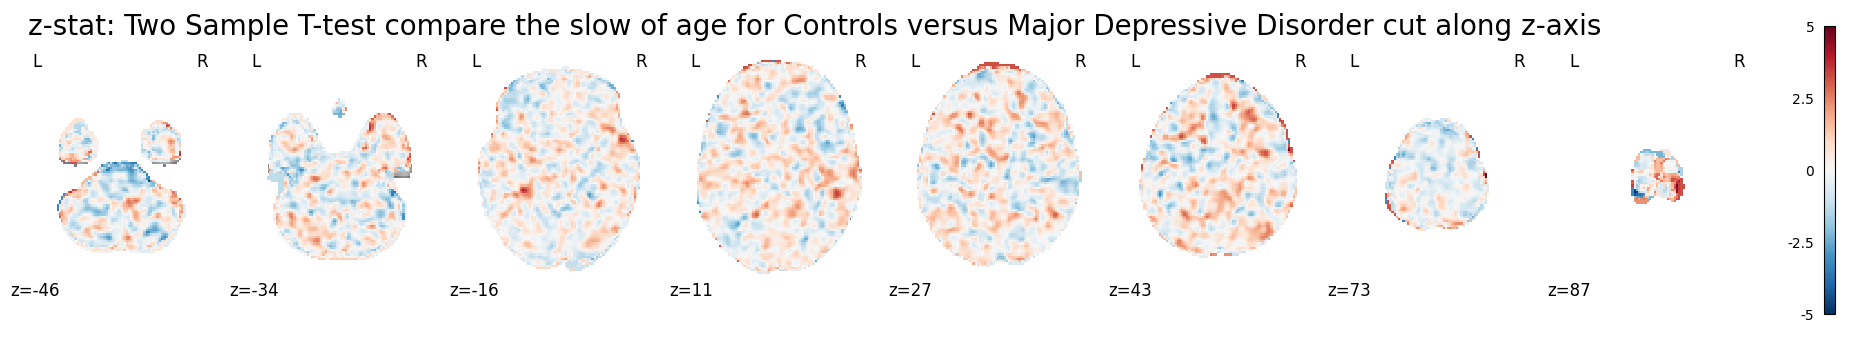

In [90]:
model = 'Two Sample T-test compare the slow of age for Controls versus Major Depressive Disorder'
map_type = 'z'
out_model = 'node-twosampleTcovint'
contrast_name = 'contrast-musicvsoundsAgeintcontrolvmdd'
img = f'{ex_results}/{out_model}/{contrast_name}_stat-{map_type}_statmap.nii.gz'
display = plot_stat_map(img, display_mode="z", cut_coords=8, 
                      title=None)
display.title(f"{map_type}-stat: {model} cut along z-axis", size=20, color='black', bgcolor='white', alpha=0)
plt.show()

## **2+ Group ANOVA**

For an ANOVA, we need at least three groups to test whether there are significant differences in brain activity across multiple conditions (H₀: μ₁ = μ₂ = μ₃ vs. H₁: at least one μᵢ ≠ μⱼ). This allows us to examine overall group effects (omnibus f-test) and perform post-hoc comparisons between specific group pairs (t-tests).


In [91]:
bids_layout = BIDSLayout(bids_inp,derivatives=False)
participants_file = bids_layout.get(suffix="participants", extension=".tsv")

Unfortunately, the only categorical grouping variables provided in the data are sex and group (which has only two levels). However, there is a wide age distribution in our sample. Therefore, we can use pandas' [qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) function to create discrete age groups that are relatively equal in sample size given the available data.

**What qcut does:**
- Divides the continuous age variable into quantile-based bins
- Creates groups with approximately equal sample sizes (balanced design)
- Converts continuous age into categorical age groups (e.g., "young", "middle", "older")


In [92]:
participants_df = pd.read_csv(participants_file[0],sep='\t')
if 'age_group' not in participants_df.columns:
    participants_df['age_group'] = pd.qcut(participants_df['age'], 
                                           q=3, 
                                           labels=['younger', 'middle', 'older'])
    
    # save
    participants_df.to_csv(participants_file[0], sep='\t', index=False)
else:
    print("age_group already exists")

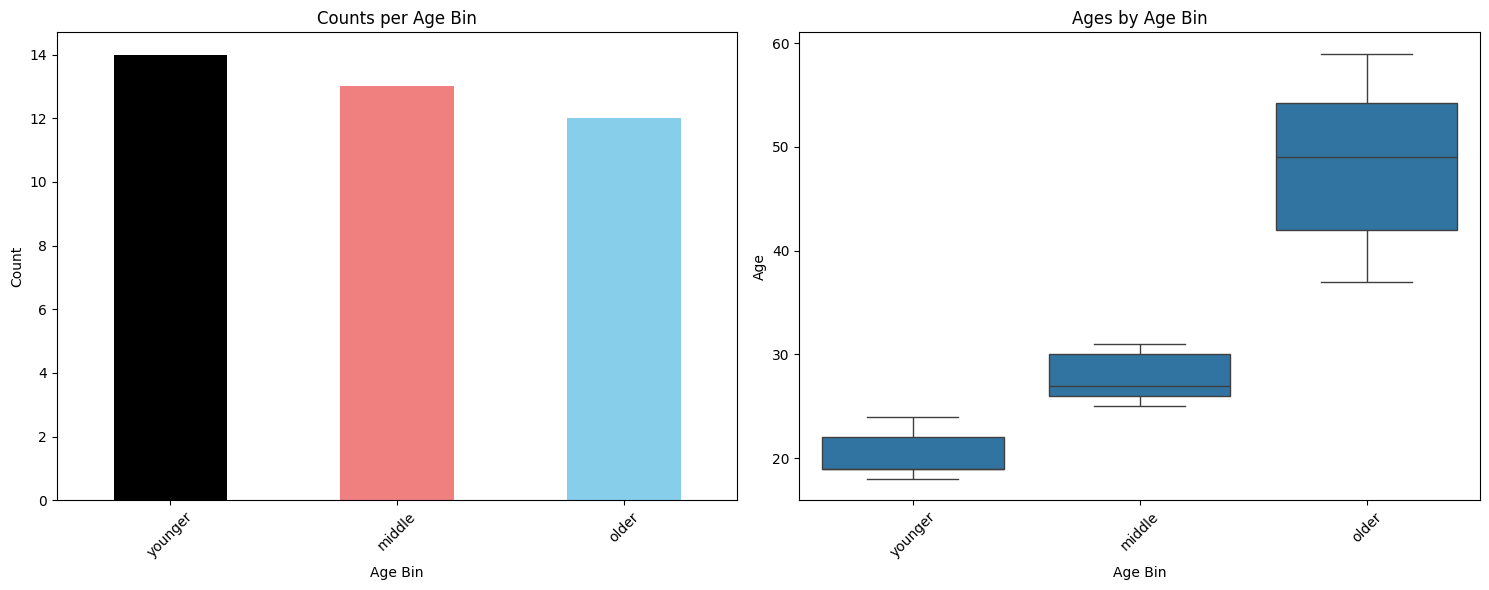

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# counts
group_counts = participants_df['age_group'].value_counts()
group_counts.plot(kind='bar', ax=ax1, color=['black', 'lightcoral', 'skyblue'])
ax1.set_title('Counts per Age Bin')
ax1.set_xlabel('Age Bin')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# hist dist
sns.boxplot(data=participants_df, x='age_group', y='age', ax=ax2)
ax2.set_title('Ages by Age Bin')
ax2.set_xlabel('Age Bin')
ax2.set_ylabel('Age')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [103]:
anova_3grp = copy.deepcopy(gen_spec)
anova_3grp['Nodes'][-1] = {
    "Level": "Dataset",
    "Name": "anova_3grp", 
    "GroupBy": [
      "contrast"
    ],
    "Transformations": {
      "Transformer": "pybids-transforms-v1",
      "Instructions": [
        {
          "Name": "Factor",
          "Input": [
            "age_group"
          ]
        }
      ]
    },
    "Model": {
      "X": [
        1,
        "age_group.*"
      ],
      "Type": "glm"
    },
    "Contrasts": [
      {
        "Name": "oldervyounger", 
        "ConditionList": [
          "age_group.older",
          "age_group.younger"
        ],
        "Weights": [
          1,
          -1
        ],
        "Test": "t"
      },
      {
        "Name": "oldervmiddle", 
        "ConditionList": [
          "age_group.older",
          "age_group.middle"
        ],
        "Weights": [
          1,
          -1
        ],
        "Test": "t"
      },
      {
        "Name": "middlevyounger", 
        "ConditionList": [
          "age_group.middle",
          "age_group.younger"
        ],
        "Weights": [
          1,
          -1
        ],
        "Test": "t"
      },
      {
        "Name": "overall_age_group_effect",
        "ConditionList": [
          "age_group.older",
          "age_group.middle", 
          "age_group.younger"
        ],
        "Weights": [
          [1, -1, 0],
          [1, 0, -1]
        ],
        "Test": "F"
      }
    ]
}
_, _, graph = get_bidstats_events(bids_inp, anova_3grp, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [104]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="anova_3grp")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

#### Data Input

Since the transformations are nearly identical to the two-sample t-test with a covariate, except we now have three groups instead of two, we will focus only on the last transformation to avoid redundancy. 

We can observe our three grouping variables that will be used in the omnibus F-test:
- Each group represents a discrete age category (e.g., young, middle, older)
- The factorization creates binary indicator columns for group membership
- These variables enable the ANOVA to test overall group differences and specific contrasts

In [105]:
grp_df = dataset_outputs[0].trans_hist[-1].output.to_df(entities=True)
grp_df.head(3)

,subject,age,age_group.middle,age_group.older,age_group.younger,group,sex,suffix
0,control01,19,0.0,0.0,1.0,Never-Depressed Control,F,participants
1,control02,22,0.0,0.0,1.0,Never-Depressed Control,M,participants
2,control03,18,0.0,0.0,1.0,Never-Depressed Control,F,participants


#### Model Matrix

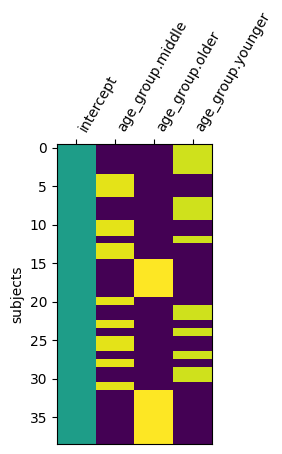

In [106]:
fig, ax = plt.subplots(figsize=(2, 0.1 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

### Statistical Maps

The F-statistic determines whether there is a significant *overall* difference in brain activation between the three age groups (older, middle, and younger) for the given contrast. This is the omnibus test, which maintains approximately 5% false-positive (Type I) error rate. Following a significant F-test, the individual contrasts within the F-test can be examined to evaluate *specific* group differences.

**Note:** The example contrasts in the specification file are *technically not* orthogonal (they share the "older" group), meaning they test partially overlapping hypotheses. If orthogonal contrasts are the goal, an alternative option is:

- C1: older vs. average of (middle + younger): [1, -0.5, -0.5]
- C2: middle vs. younger: [0, 1, -1]

These two contrasts evaluate two *independent* hypotheses, which would not require further family-wise error rate (FWER) or false discovery rate (FDR) corrections beyond the already stringent thresholding and cluster corrections.

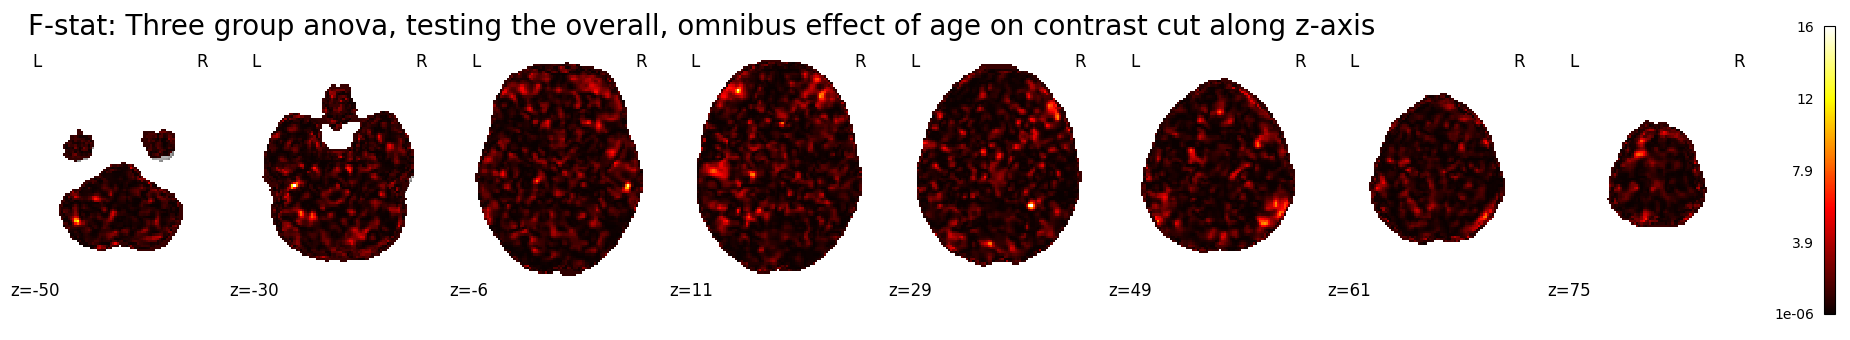

In [108]:
model = 'Three group anova, testing the overall, omnibus effect of age on contrast'
map_type = 'F'
out_model = 'node-anova3Grp'
contrast_name = 'contrast-posmusicvsoundsOverallAgeGroupEffect'
img = f'{ex_results}/{out_model}/{contrast_name}_stat-{map_type}_statmap.nii.gz'
display = plot_stat_map(img, display_mode="z", cut_coords=8, 
                      title=None, cmap='hot') # f-stat is all positive, so set to hot so 0 is black instead of blue as is deault
display.title(f"{map_type}-stat: {model} cut along z-axis", size=20, color='black', bgcolor='white', alpha=0)
plt.show()